In [39]:
from aeon.datasets import (
    load_classification,
    load_forecasting,
    load_regression,
    load_from_tsv_file

)
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, RidgeClassifierCV, RidgeClassifier
import pywt
from pyts.image import MarkovTransitionField
from pyts.image import GramianAngularField
from pyts.image import RecurrencePlot
from aeon.transformations.detrend import Deseasonalizer
from scipy.signal import stft
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
def znorm(x):
  x_znorm = (x - np.mean(x)) / np.std(x)
  return x_znorm


def normalize_series_znorm(X, representation, wavelet, level):
    rep = []
    # X_train_series = X.flatten()

    # transform = Deseasonalizer(sp=12)
    # transform.fit(X_train_series)
    # X_train_deseasonal = transform.transform(X_train_series)
    # X_train_flat_reshaped = X_train_deseasonal.reshape(X.shape)

    X_train_flat_reshaped = X
    for x in X_train_flat_reshaped:
      # x_normalized = znorm(x)
      x_normalized = x
      transformed = transform_series2(x_normalized, representation, wavelet, level)
      rep.append(znorm(transformed))
    new = np.array(rep)
    return new.reshape(new.shape[0], -1)

def flatten_series(X):
    return X.reshape(X.shape[0], -1)

def flatten_labels(y):
    return np.ravel(y)

def transform_series2(series, representation, wavelet, level):
  # series = np.array(znorm(series))
  if representation == "CWT":
    coeffs, freqs = pywt.cwt(series, scales=np.arange(1, len(series) + 1), wavelet=wavelet) # morl
    im_final = coeffs
  elif representation == "DWT":
    coeffs = pywt.wavedec(series, wavelet=wavelet, level=level)
    cA2, cD2, cD1 = coeffs
    im_final = np.concatenate(coeffs, axis=0)
  elif representation == "SWT":
    coeffs_swt = pywt.swt(series, wavelet, level=level)
    im_final = np.concatenate([coeff[0] for coeff in coeffs_swt] + [coeff[1] for coeff in coeffs_swt], axis=0)

  elif representation == "Comb1":
    wp = pywt.WaveletPacket(data=series, wavelet='db1', mode='periodization')
    nodes = wp.get_level(2, order='freq')
    coeffs_wpt = np.array([n.data for n in nodes])

    f, t, Zxx = stft(series,window='hann', nperseg=64)
    coeffs_stft = np.abs(Zxx)
    coeffs_stft_flat = coeffs_stft.flatten()
    coeffs_wpt_flat = coeffs_wpt.flatten()
    im_final = np.concatenate([coeffs_stft_flat, coeffs_wpt_flat])
  elif representation == "Comb2":
    wp = pywt.WaveletPacket(data=series, wavelet='db1', mode='symmetric')
    nodes = wp.get_level(2, order='freq')
    coeffs_wpt = np.array([n.data for n in nodes])

    f, t, Zxx = stft(series,window='hann', nperseg=64)
    coeffs_stft = np.abs(Zxx)
    coeffs_stft_flat = coeffs_stft.flatten()
    coeffs_wpt_flat = coeffs_wpt.flatten()

    coeffs_dft = np.fft.fft(series)
    coeffs_dft = np.abs(coeffs_dft)
    coeffs_dft_flat = coeffs_dft.flatten()

    U, s, V = np.linalg.svd(series.reshape(-1, 1))
    coeffs_svd_flat = s.flatten()
    im_final = np.concatenate([coeffs_stft_flat, coeffs_dft_flat, coeffs_svd_flat, coeffs_wpt_flat])
  elif representation == "Comb3":
    wp = pywt.WaveletPacket(data=series, wavelet='db1', mode='symmetric')
    nodes = wp.get_level(2, order='freq')
    coeffs_wpt = np.array([n.data for n in nodes])

    f, t, Zxx = stft(series,window='hann', nperseg=64)
    coeffs_stft = np.abs(Zxx)
    coeffs_stft_flat = coeffs_stft.flatten()
    coeffs_wpt_flat = coeffs_wpt.flatten()

    U, s, V = np.linalg.svd(series.reshape(-1, 1))
    coeffs_svd_flat = s.flatten()
    im_final = np.concatenate([coeffs_stft_flat, coeffs_dft_flat, coeffs_svd_flat])
  elif representation == "DFT":
    coeffs_dft = np.fft.fft(series)
    coeffs_dft = np.abs(coeffs_dft)
    im_final = coeffs_dft
  elif representation == "SVD":
    U, s, V = np.linalg.svd(series.reshape(-1, 1))
    im_final = s
  elif representation == "WPT":
    wp = pywt.WaveletPacket(data=series, wavelet='db1', mode='symmetric')

    # Extrair os coeficientes em diferentes níveis
    nodes = wp.get_level(4, order='freq')  # Pegando o 4º nível de decomposição
    coeffs_wpt = np.array([n.data for n in nodes])

    # Concatenar os coeficientes para visualização
    im_final = np.concatenate(coeffs_wpt, axis=0)
  elif representation == "STFT":
    f, t, Zxx = stft(series,window='hann', nperseg=64)

    # Obter a magnitude dos coeficientes
    coeffs_stft = np.abs(Zxx)

    # Concatenar os coeficientes para criar im_final
    im_final = coeffs_stft

  elif representation == "MTF":
    series = series.reshape(1, len(series))
    mtf = MarkovTransitionField(strategy='normal') #n_bins=4, strategy='uniform'
    X_mtf = mtf.fit_transform(series)
    im_final = X_mtf[0]
  elif representation == "GADF":
    series = series.reshape(1, len(series))
    gaf = GramianAngularField(method='difference')
    X_gaf = gaf.fit_transform(series)
    im_final = X_gaf[0]
  elif representation == "GASF":
    series = series.reshape(1, len(series))
    gaf = GramianAngularField(method='summation')
    X_gaf = gaf.fit_transform(series)
    im_final = X_gaf[0]
  elif representation == "RP":
    series = series.reshape(1, len(series))
    rp = RecurrencePlot(threshold='distance')
    X_rp = rp.fit_transform(series)
    im_final = X_rp[0]
  elif representation == "FIRTS":
    series = series.reshape(1, len(series))
    mtf = MarkovTransitionField(n_bins=4, strategy='uniform')
    X_mtf = mtf.fit_transform(series)
    gaf = GramianAngularField(method='difference')
    X_gaf = gaf.fit_transform(series)
    rp = RecurrencePlot(threshold='distance')
    X_rp = rp.fit_transform(series)
    im_final = (X_mtf[0] + X_gaf[0] + X_rp[0]) # FIRTS é fusão entre MTF, GADF e RP (vejam o artigo que passei para vocês)
  return im_final

def load_ucr_data(train_file, test_file):
    # Ler o arquivo de treino
    train_data = pd.read_csv(train_file, sep='\t', header=None)
    # Ler o arquivo de teste
    test_data = pd.read_csv(test_file, sep='\t', header=None)
    
    # Separar os rótulos (a primeira coluna) e as features (restantes das colunas)
    X_train = train_data.iloc[:, 1:].values  # Features de treino (todas as colunas menos a primeira)
    y_train = train_data.iloc[:, 0].values   # Rótulos de treino (primeira coluna)
    
    X_test = test_data.iloc[:, 1:].values    # Features de teste (todas as colunas menos a primeira)
    y_test = test_data.iloc[:, 0].values     # Rótulos de teste (primeira coluna)
    
    return X_train, X_test, y_train, y_test


In [40]:
def get_weights_validation(X_train, y_train, transformations):
    pesos = []
    for transform in transformations:
        X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        X_train_flattened = flatten_series(X_train_val)
        X_test_flattened = flatten_series(X_test_val)
        X_train_normalized = normalize_series_znorm(X_train_flattened, transform, "bior2.2", 2)
        X_test_normalized = normalize_series_znorm(X_test_flattened, transform, "bior2.2", 2)
        y_train_flattened = flatten_labels(y_train_val)
        y_test_flattened = flatten_labels(y_test_val)

        # classifier = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10))
        classifier = RandomForestClassifier(n_estimators=200, random_state=42)
        classifier.fit(X_train_normalized, y_train_flattened)

        y_pred = classifier.predict(X_test_normalized)
        accuracy = accuracy_score(y_test_flattened, y_pred)
        accuracy = round(accuracy, 4)

        pesos.append(accuracy)

    pesos = np.array(pesos)
    pesos_normalizados = pesos / np.sum(pesos)

    return pesos_normalizados


def generate_ponderate_features(X_train, X_test, weights, transformations):
    X_train_finais = []
    X_test_finais = []
    for i, transformacao in enumerate(transformations):
        X_train_transformado = normalize_series_znorm(X_train, transformacao, "bior2.2", 2)
        X_test_transformado = normalize_series_znorm(X_test, transformacao, "bior2.2", 2)
        
        X_train_ponderado = weights[i] * X_train_transformado
        X_test_ponderado = weights[i] * X_test_transformado
        
        X_train_finais.append(X_train_ponderado)
        X_test_finais.append(X_test_ponderado)

    try:
        X_train_finais = np.concatenate(X_train_finais, axis=1)
        X_test_finais = np.concatenate(X_test_finais, axis=1)
    except ValueError as e:
        print(f"Erro de concatenação: {e}")
        return None, None
    
    return X_train_finais, X_test_finais


In [58]:
rivals = pd.read_csv('./rival Lucas.csv')

# from aeon.transformations.collection.convolution_based import Rocket
accuracies = []
representation = "Comb2" #melhores STFT/DWT/WPT
wavelet = "db1" #melhor wavelet para DWT e WPT
level = 2 #melhor level
resultados = pd.DataFrame(columns=['Dataset', 'Comb2-rf'])
cont = 0
transformations = ["DFT",  "WPT", "Comb2"]
rivals = pd.read_csv('./rival Lucas.csv')
# for name in rivals['Datasets'].tolist():
for name in ["Fish", "CricketX", "CricketY", "CricketZ", "Ham", "CBF"]:

        # Verifica se ambos os arquivos foram encontrados
        print(f'Processando: {name}')
        try:
            # Carrega os dados
            X_train, X_test, y_train, y_test = load_ucr_data(f'../UCRArchive_2018/{name}/{name}_TRAIN.tsv', f'../UCRArchive_2018/{name}/{name}_TEST.tsv')

            pesos  = get_weights_validation(X_train, y_train, transformations)

            # Normaliza os dados
            X_train_flattened = flatten_series(X_train)
            X_test_flattened = flatten_series(X_test)
        #   X_train_normalized = normalize_series_znorm(X_train_flattened, representation, wavelet, level)
        #   X_test_normalized = normalize_series_znorm(X_test_flattened, representation, wavelet, level)
            y_train_flattened = flatten_labels(y_train)
            y_test_flattened = flatten_labels(y_test)

            X_train_final, X_test_final = generate_ponderate_features(X_train, X_test, pesos, transformations)
            # trf = Rocket(num_kernels=512)
            # trf.fit(X_train)

            # X_train = trf.transform(X_train)
            # X_test = trf.transform(X_test)

            # clf = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10), normalize = True)
            # clf.fit(X_train, y_train)

            # Cria e treina o modelo
            clf = RandomForestClassifier(n_estimators=200, random_state=42)
            clf.fit(X_train_final, y_train_flattened)

            y_pred = clf.predict(X_test_final)
            accuracy = accuracy_score(y_test_flattened, y_pred)
            accuracy = round(accuracy, 4)
            print(accuracy)
            resultados = pd.concat([resultados, pd.DataFrame({'Dataset': [name], 'Comb2-rf': [accuracy]})], ignore_index=True)
        except Exception as e:
            print(e)
            print(f'Crashou dataset: {name}')
            # if cont == 5: break

# resultados.to_csv('resultados.csv', index=False)

Processando: Fish


0.7314
Processando: CricketX
0.5513
Processando: CricketY


KeyboardInterrupt: 

In [42]:
# import os
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# # from aeon.transformations.collection.convolution_based import Rocket
# accuracies = []
# representation = "WPT" #melhores STFT/DWT/WPT
# wavelet = "db1" #melhor wavelet para DWT e WPT
# level = 2 #melhor level
# resultados = pd.DataFrame(columns=['Dataset', 'Comb2-rf'])
# cont = 0
# transformations = ["STFT", "DFT", "SVD", "WPT"]
# rivals = pd.read_csv('./rival Lucas.csv')
# for raiz, pastas, arquivos in os.walk('../UCRArchive_2018'):
#         cont +=1
#         train_file = None
#         test_file = None

#         for arquivo in arquivos:
#             if arquivo.endswith('_TRAIN.tsv'):
#                 train_file = os.path.join(raiz, arquivo)
#             elif arquivo.endswith('_TEST.tsv'):
#                 test_file = os.path.join(raiz, arquivo)
#         dataset_name = os.path.basename(raiz)
#         # Verifica se ambos os arquivos foram encontrados
#         if train_file and test_file:
#             print(f'Processando: {train_file} e {test_file}')
#             try:
#               # Carrega os dados
#                 X_train, X_test, y_train, y_test = load_ucr_data(train_file, test_file)

#                 pesos = get_weights_validation(X_train, y_train, transformations)

#                 # Normaliza os dados
#                 X_train_flattened = flatten_series(X_train)
#                 X_test_flattened = flatten_series(X_test)
#             #   X_train_normalized = normalize_series_znorm(X_train_flattened, representation, wavelet, level)
#             #   X_test_normalized = normalize_series_znorm(X_test_flattened, representation, wavelet, level)
#                 y_train_flattened = flatten_labels(y_train)
#                 y_test_flattened = flatten_labels(y_test)

#                 X_train_final, X_test_final = generate_ponderate_features(X_train, X_test, pesos, transformations)
#                 # trf = Rocket(num_kernels=512)
#                 # trf.fit(X_train)

#                 # X_train = trf.transform(X_train)
#                 # X_test = trf.transform(X_test)

#                 # clf = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10), normalize = True)
#                 # clf.fit(X_train, y_train)

#                 # Cria e treina o modelo
#                 clf = RandomForestClassifier(n_estimators=200, random_state=42)
#                 clf.fit(X_train_final, y_train_flattened)

#                 y_pred = clf.predict(X_test_final)
#                 accuracy = accuracy_score(y_test_flattened, y_pred)
#                 accuracy = round(accuracy, 4)
#                 print(accuracy)
#                 resultados = pd.concat([resultados, pd.DataFrame({'Dataset': [dataset_name], 'Comb2-rf': [accuracy]})], ignore_index=True)
#             except Exception as e:
#               print(e)
#               print(f'Crashou dataset: {dataset_name}')
#             # if cont == 5: break

# # resultados.to_csv('resultados.csv', index=False)

In [43]:
rocket = pd.read_csv('./rocket_ucr.csv')

In [44]:
rocket_filter = rocket[rocket['dataset'].isin(rivals['Datasets'])]
df_concat_rocket = rivals.merge(
    rocket_filter[['dataset', 'accuracy_mean']],  # Seleciona apenas as colunas relevantes
    left_on='Datasets',                           # Coluna do DataFrame rivals
    right_on='dataset',                           # Coluna do DataFrame rocket_filter
    how='left'                                    # Faz um merge à esquerda
)

df_concat_rocket.drop(columns=['dataset'], inplace=True)
df_concat_rocket.rename(columns={'accuracy_mean': 'Rocket'}, inplace=True)
df_concat_rocket

,Datasets,ST,BOSS,TSF,EE,Flat-COTE,HIVE-COTE,ResNet,Rocket
0,Adiac,0.782609,0.764706,0.731458,0.664962,0.790281,0.810742,0.813299,0.767519
1,ArrowHead,0.737143,0.834286,0.725714,0.811429,0.811429,0.862857,0.811429,0.866286
2,Beef,0.900000,0.800000,0.766667,0.633333,0.866667,0.933333,0.766667,0.753333
3,BeetleFly,0.900000,0.900000,0.750000,0.750000,0.800000,0.950000,0.850000,0.890000
4,BirdChicken,0.800000,0.950000,0.800000,0.800000,0.900000,0.850000,0.900000,0.860000
...,...,...,...,...,...,...,...,...,...
80,Wine,0.796296,0.740741,0.629630,0.574074,0.648148,0.777778,0.833333,0.938889
81,WordSynonyms,0.570533,0.637931,0.647335,0.778997,0.757053,0.738245,0.603448,0.762382
82,Worms,0.740260,0.558442,0.610390,0.662338,0.623377,0.558442,0.753247,0.724675
83,WormsTwoClass,0.831169,0.831169,0.623377,0.688312,0.805195,0.779221,0.753247,0.780519


In [45]:
resultados_filtrados = resultados[resultados['Dataset'].isin(rivals['Datasets'])]

# Renomeia a coluna de acurácia para 'MeuModelo'
resultados_filtrados = resultados_filtrados.rename(columns={'Comb2-rf': 'Comb2-RF'})

# Mescla o DataFrame rivals com os resultados filtrados
df_resultados_final = df_concat_rocket.merge(resultados_filtrados[['Dataset', 'Comb2-RF']],
                                    left_on='Datasets',
                                    right_on='Dataset',
                                    how='left')

# Remove a coluna 'Dataset' do resultado da mesclagem
df_resultados_final = df_resultados_final.drop(columns=['Dataset'])
df_resultados_final.to_csv('concat_rival.csv', index=False)

In [46]:
# Author: Hassan Ismail Fawaz <hassan.ismail-fawaz@uha.fr>
#         Germain Forestier <germain.forestier@uha.fr>
#         Jonathan Weber <jonathan.weber@uha.fr>
#         Lhassane Idoumghar <lhassane.idoumghar@uha.fr>
#         Pierre-Alain Muller <pierre-alain.muller@uha.fr>
# License: GPL3

import numpy as np
import pandas as pd
import matplotlib

matplotlib.use('agg')
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

import operator
import math
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare
import networkx

%matplotlib inline

# inspired from orange3 https://docs.orange.biolab.si/3/data-mining-library/reference/evaluation.cd.html
def graph_ranks(avranks, names, p_values, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, labels=False, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
        labels (bool, optional): if set to `True`, the calculated avg rank
        values will be displayed
    """
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=2)

    bigtick = 0.3
    smalltick = 0.15
    linewidth = 2.0
    linewidth_sign = 4.0

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=2)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="right", va="center", size=10)
        text(textspace - 0.2, chei, filter_names(nnames[i]), ha="right", va="center", size=16)

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + scalewidth - 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="left", va="center", size=10)
        text(textspace + scalewidth + 0.2, chei, filter_names(nnames[i]),
             ha="left", va="center", size=16)

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            print('drawing: ', l, r)

    # draw_lines(lines)
    start = cline + 0.2
    side = -0.02
    height = 0.1

    # draw no significant lines
    # get the cliques
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    print(nnames)
    for clq in cliques:
        if len(clq) == 1:
            continue
        print(clq)
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign)
        start += height


def form_cliques(p_values, nnames):
    """
    This method forms the cliques
    """
    # first form the numpy matrix data
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1

    g = networkx.Graph(g_data)
    return networkx.find_cliques(g)


def draw_cd_diagram(df_perf=None, alpha=0.05, title=None, labels=False):
    """
    Draws the critical difference diagram given the list of pairwise classifiers that are
    significant or not
    """
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_perf, alpha=alpha)

    print(average_ranks)

    for p in p_values:
        print(p)


    graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
                cd=None, reverse=True, width=9, textspace=1.5, labels=labels)

    font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 22,
        }
    if title:
        plt.title(title,fontdict=font, y=0.9, x=0.5)
    plt.savefig('cd-diagram.png', dpi=300, bbox_inches='tight')

def wilcoxon_holm(alpha=0.05, df_perf=None):
    """
    Applies the wilcoxon signed rank test between each pair of algorithm and then use Holm
    to reject the null's hypothesis
    """
    print(pd.unique(df_perf['classifier_name']))
    # count the number of tested datasets per classifier
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        ['classifier_name']).size()}).reset_index()
    # get the maximum number of tested datasets
    max_nb_datasets = df_counts['count'].max()
    # get the list of classifiers who have been tested on nb_max_datasets
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       ['classifier_name'])
    # test the null hypothesis using friedman before doing a post-hoc analysis
    friedman_p_value = friedmanchisquare(*(
        np.array(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
        for c in classifiers))[1]
    if friedman_p_value >= alpha:
        # then the null hypothesis over the entire classifiers cannot be rejected
        print('the null hypothesis over the entire classifiers cannot be rejected')
        exit()
    # get the number of classifiers
    m = len(classifiers)
    # init array that contains the p-values calculated by the Wilcoxon signed rank test
    p_values = []
    # loop through the algorithms to compare pairwise
    for i in range(m - 1):
        # get the name of classifier one
        classifier_1 = classifiers[i]
        # get the performance of classifier one
        perf_1 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_1]['accuracy']
                          , dtype=np.float64)
        for j in range(i + 1, m):
            # get the name of the second classifier
            classifier_2 = classifiers[j]
            # get the performance of classifier one
            perf_2 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_2]
                              ['accuracy'], dtype=np.float64)
            # calculate the p_value
            p_value = wilcoxon(perf_1, perf_2, zero_method='pratt')[1]
            # appen to the list
            p_values.append((classifier_1, classifier_2, p_value, False))
    # get the number of hypothesis
    k = len(p_values)
    # sort the list in acsending manner of p-value
    p_values.sort(key=operator.itemgetter(2))

    # loop through the hypothesis
    for i in range(k):
        # correct alpha with holm
        new_alpha = float(alpha / (k - i))
        # test if significant after holm's correction of alpha
        if p_values[i][2] <= new_alpha:
            p_values[i] = (p_values[i][0], p_values[i][1], p_values[i][2], True)
        else:
            # stop
            break
    # compute the average ranks to be returned (useful for drawing the cd diagram)
    # sort the dataframe of performances
    sorted_df_perf = df_perf.loc[df_perf['classifier_name'].isin(classifiers)]. \
        sort_values(['classifier_name', 'dataset_name'])
    # get the rank data
    rank_data = np.array(sorted_df_perf['accuracy']).reshape(m, max_nb_datasets)

    # create the data frame containg the accuracies
    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers), columns=
    np.unique(sorted_df_perf['dataset_name']))

    # number of wins
    dfff = df_ranks.rank(ascending=False)
    print(dfff[dfff == 1.0].sum(axis=1))

    # average the ranks
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    # return the p-values and the average ranks
    return p_values, average_ranks, max_nb_datasets

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

['ST' 'BOSS' 'TSF' 'EE' 'Flat-COTE' 'HIVE-COTE' 'ResNet' 'Rocket'
 'Comb2-RF']
BOSS          5.0
Comb2-RF      0.0
EE            3.0
Flat-COTE     2.0
HIVE-COTE    12.0
ResNet       13.0
Rocket       36.0
ST            2.0
TSF           0.0
dtype: float64
Comb2-RF     8.333333
TSF          6.058824
EE           5.952941
BOSS         5.323529
ST           4.847059
ResNet       4.317647
Flat-COTE    3.858824
HIVE-COTE    2.970588
Rocket       2.654762
dtype: float64
('BOSS', 'Comb2-RF', nan, False)
('EE', 'Flat-COTE', 1.5361871295181725e-11, False)
('EE', 'HIVE-COTE', 1.6817174162829648e-11, False)
('Flat-COTE', 'TSF', 2.5222801067115645e-10, False)
('BOSS', 'HIVE-COTE', 3.885453102189332e-10, False)
('HIVE-COTE', 'ST', 1.9223846527868922e-07, False)
('BOSS', 'Flat-COTE', 1.1602729018364703e-05, False)
('ResNet', 'TSF', 1.2172229849609158e-05, False)
('EE', 'ResNet', 0.00010406717520869547, False)
('Flat-COTE', 'HIVE-COTE', 0.0005741067469950771, False)
('ST', 'TSF', 0.000834139520082892

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

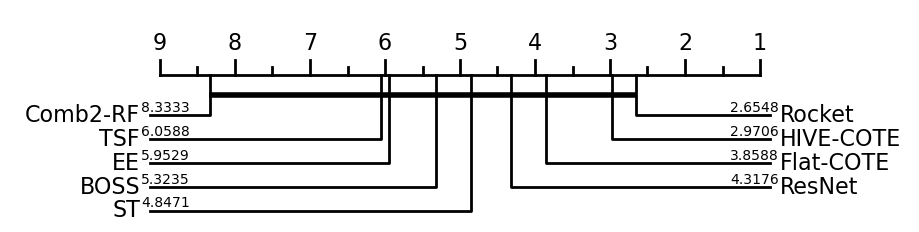

In [47]:
data = pd.read_csv("concat_rival.csv",index_col=False, delimiter=',') # primeira coluna é Datasets e as outras são os nomes dos classificadores. Tirei o index do CSV
df = data.melt(id_vars=['Datasets'], var_name='classifier_name', value_name='accuracy')
df.rename(columns = {'Datasets':'dataset_name'}, inplace = True)
draw_cd_diagram(df_perf=df, alpha=0.05, title="", labels=True)